# Emotion classification using the RAVDESS dataset

The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) is licensed under CC BY-NA-SC 4.0. and can be downloaded free of charge at https://zenodo.org/record/1188976.

***Construction and Validation***

Construction and validation of the RAVDESS is described in our paper: Livingstone SR, Russo FA (2018) The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS): A dynamic, multimodal set of facial and vocal expressions in North American English. PLoS ONE 13(5): e0196391. https://doi.org/10.1371/journal.pone.0196391.

The RAVDESS contains 7356 files. Each file was rated 10 times on emotional validity, intensity, and genuineness. Ratings were provided by 247 individuals who were characteristic of untrained adult research participants from North America. A further set of 72 participants provided test-retest data. High levels of emotional validity, interrater reliability, and test-retest intrarater reliability were reported. Validation data is open-access, and can be downloaded along with our paper from PLOS ONE.

***Description***

The dataset contains the complete set of 7356 RAVDESS files (total size: 24.8 GB). Each of the 24 actors consists of three modality formats: Audio-only (16bit, 48kHz .wav), Audio-Video (720p H.264, AAC 48kHz, .mp4), and Video-only (no sound).  Note, there are no song files for Actor_18.

***Data***

For this task, I have used 4948 samples from the RAVDESS dataset.

The samples comes from:

- Audio-only files;
- Video + audio files: I have extracted the audio from each file using the script Mp4ToWav.py that you can find in the main directory of the project.

***License information***

The RAVDESS is released under a Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License, CC BY-NA-SC 4.0

***File naming convention***

Each of the 7356 RAVDESS files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 02-01-06-01-02-01-12.mp4). These identifiers define the stimulus characteristics:

***Filename identifiers***

- Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
- Vocal channel (01 = speech, 02 = song).
- Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
- Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the ‘neutral’ emotion.
- Statement (01 = “Kids are talking by the door”, 02 = “Dogs are sitting by the door”).
- Repetition (01 = 1st repetition, 02 = 2nd repetition).
- Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Filename example: 02-01-06-01-02-01-12.mp4 

- Video-only (02)
- Speech (01)
- Fearful (06)
- Normal intensity (01)
- Statement “dogs” (02)
- 1st Repetition (01)
- 12th Actor (12)
- Female, as the actor ID number is even.

# Analysis

We are using Colab, a Google Cloud environment for jupyter, so we need to import our files from Google Drive and then install LibROSA, a python package for music and audio analysis.

After the import, we will plot the signal of the first file.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install librosa

In [0]:
import librosa
from librosa import display

data, sampling_rate = librosa.load('/content/drive/My Drive/Ravdess/03-02-01-01-01-01-01.wav')

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['display']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


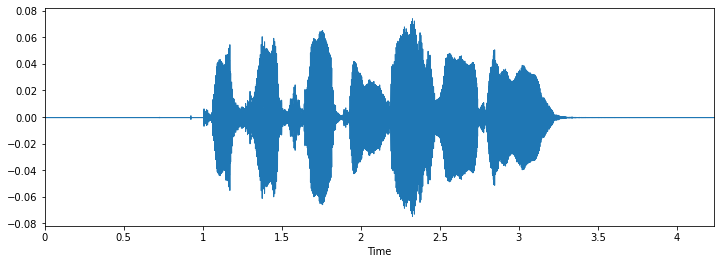

In [5]:
% pylab inline
import os
import pandas as pd
import glob 

plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, sr=sampling_rate)

# Load all files

We will create our numpy array extracting Mel-frequency cepstral coefficients (MFCCs), while the classes to predict will be extracted from the name of the file (see the introductory section of this notebook to see the naming convention of the files of this dataset).

In [6]:
import time

path = '/content/drive/My Drive/Ravdess/'
lst = []

start_time = time.time()

for subdir, dirs, files in os.walk(path):
  for file in files:
      try:
        #Load librosa array, obtain mfcss, store the file and the mcss information in a new array
        X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
        # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
        # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
        file = int(file[7:8]) - 1 
        arr = mfccs, file
        lst.append(arr)
      # If the file is not valid, skip it
      except ValueError:
        continue

print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

--- Data loaded. Loading time: 427.14971899986267 seconds ---


In [0]:
# Creating X and y: zip makes a list of all the first elements, and a list of all the second elements.
X, y = zip(*lst)

In [8]:
import numpy as np
X = np.asarray(X)
y = np.asarray(y)


X.shape, y.shape

((1012, 40), (1012,))

In [0]:
# Saving joblib files to not load them again with the loop above

import joblib

X_name = 'X.joblib'
y_name = 'y.joblib'
save_dir = '/content/drive/My Drive/Ravdess_model'

savedX = joblib.dump(X, os.path.join(save_dir, X_name))
savedy = joblib.dump(y, os.path.join(save_dir, y_name))

In [0]:
# Loading saved models

X = joblib.load('/content/drive/My Drive/Ravdess_model/X.joblib')
y = joblib.load('/content/drive/My Drive/Ravdess_model/y.joblib')

# Decision Tree Classifier

To make a first attempt in accomplishing this classification task I chose a decision tree:

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [0]:
from sklearn.tree import DecisionTreeClassifier

In [0]:
dtree = DecisionTreeClassifier()

In [14]:
dtree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [0]:
predictions = dtree.predict(X_test)

Let's go with our classification report.

Before we start, a quick reminder of the classes we are trying to predict:

emotions = {
    "neutral": "0",
    "calm": "1",
    "happy": "2",
    "sad": "3",
    "angry": "4", 
    "fearful": "5", 
    "disgust": "6", 
    "surprised": "7"
}

In [16]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.66      0.76      0.70        25
           1       0.76      0.79      0.77        61
           2       0.69      0.63      0.66        65
           3       0.57      0.52      0.54        62
           4       0.67      0.67      0.67        67
           5       0.53      0.59      0.56        54

    accuracy                           0.65       334
   macro avg       0.65      0.66      0.65       334
weighted avg       0.65      0.65      0.65       334



# Random Forest

In this second approach, I switched to a random forest classifier and I made a gridsearch to make some hyperparameters tuning.

The gridsearch is not shown in the code below otherwise the notebook will require too much time to run.

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
rforest = RandomForestClassifier(criterion="gini", max_depth=10, max_features="log2", 
                                 max_leaf_nodes = 100, min_samples_leaf = 3, min_samples_split = 20, 
                                 n_estimators= 22000, random_state= 5)

In [19]:
rforest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='log2',
                       max_leaf_nodes=100, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=22000,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)

In [0]:
predictions = rforest.predict(X_test)

In [21]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90        25
           1       0.78      0.95      0.86        61
           2       0.90      0.69      0.78        65
           3       0.79      0.71      0.75        62
           4       0.83      0.87      0.85        67
           5       0.59      0.63      0.61        54

    accuracy                           0.78       334
   macro avg       0.79      0.79      0.79       334
weighted avg       0.79      0.78      0.78       334



# Thank you for your attention! To be continued..